In [37]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras import layers
import time
from IPython import display

# we don't need test data in GAN networks :


In [38]:
# import MNIST dataset
#(train_images , train_labels) ,(test_images,test_labels) = tf.keras.datasets.mnist.load_data()
# in training GAN networks , there is no need to test data ,
# so we replace test data(test_images,test_labels) with (_,_)

(train_images , train_labels) ,(_,_) = tf.keras.datasets.mnist.load_data()

# Normalizing pixels :

In [39]:
# reshaping images to size 28*28 , and bc they are grayscale we consider only one channel for them .
train_images = train_images.reshape(train_images.shape[0] ,28,28,1).astype("float32")
# we have 2 types of NORMALIZING :
# divide pixels value into 255 ---> result will be in range of [0,1]
# subtract 255/2=127.5 from pixels then divide them to 127.5
train_images = (train_images -127.5) / 127.5 #normalize images to [-1 , 1]

# Hyperparameters :

In [40]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# shuffle train data & define batch :

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the models :

# discriminator : (convolution)

In [42]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64 , (5,5) , strides=(2,2) , padding="same" , input_shape=[28,28,1]))

  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters=128 , kernel_size=(5,5) , strides=(2,2) ,padding="same"))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1)) # 1 neuron in last layer bc of classification (real / fake)

  return model


# GENERATOR :

In [43]:
def make_generator_model():
  model = tf.keras.Sequential()
  # here in first layer , we have dense
  model.add(layers.Dense(7*7*256 , use_bias=False , input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7,7,256)))

  # deconvolution
  model.add(layers.Conv2DTranspose(filters=128 , kernel_size=(5,5) , strides=(1,1) ,padding="same" , use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(filters=64 , kernel_size=(5,5) , strides=(2,2) ,padding="same" , use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # here in last layer , we have an image
  model.add(layers.Conv2DTranspose(filters=1 , kernel_size=(5,5) , strides=(2,2) ,padding="same" , use_bias=False ,activation="tanh"))

  return model

In [44]:
generator = make_generator_model()
noise = tf.random.normal((1,100))
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 6.4270574e-01,  1.3359981e+00, -1.3053768e+00, -6.0099566e-01,
        -3.6476022e-01,  5.3018689e-01, -7.9806352e-01,  6.8007773e-01,
         1.5037611e+00,  8.0531135e-02, -5.0530648e-01, -2.7687389e-01,
        -3.8528547e-01, -9.2264259e-01,  8.0064410e-01,  6.3022786e-01,
        -9.8219675e-01, -5.4004985e-01,  9.6238774e-01, -5.1214778e-01,
         3.7123820e-01, -8.6074054e-01,  1.0892173e+00,  1.0732868e+00,
         3.1704685e-01, -1.7459445e+00,  1.6753974e+00,  1.2548726e+00,
        -7.4417281e-01,  8.5026979e-01,  4.4446003e-02, -6.9801503e-01,
         2.5750577e-01,  7.2154385e-01,  4.0054742e-01,  1.0805073e+00,
         6.2619507e-02, -5.7629532e-01, -5.8751378e-02,  5.3289540e-02,
         4.8570466e-01, -2.6720625e-01,  6.6706282e-01, -1.1401274e+00,
        -7.1411037e-01, -7.0356166e-01, -2.7702808e+00,  3.6809140e-01,
        -1.5200062e+00,  7.0563126e-01,  7.7984101e-01, -5.4572845e-01,
        -2.026

# input of the GAN is noise

In [45]:
# give noise to generator , and want an output from it without any training
generated_image = generator(noise , training=False)

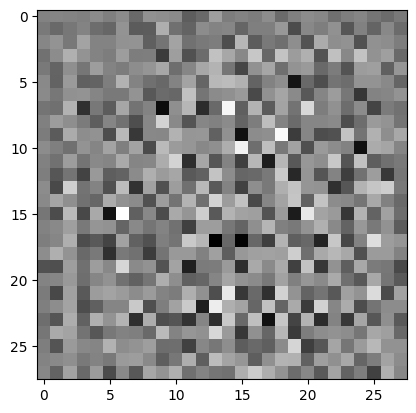

In [46]:
plt.imshow(generated_image[0 , : , : , 0] , cmap="gray")

# it's random Because it has not yet been trained .
and generator's weights are random .

## call discriminator function :

In [47]:
discriminator  = make_discriminator_model()

# now give this random image to discriminator :
# it will also give a random answer , bc its not been trained yet
decision = discriminator(generated_image)
decision

# if decision > 0.5  = real
# if decision < 0.5  = fake

# so   :
# discriminator says that generated image is fake image

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00157164]], dtype=float32)>

# both of the discriminator and generator have to be trained , to give true outputs

we compute loss from discriminator output , loss should be binarycrossentropy , bc its a classification problem .

categoricalcrossentropy is for multiple class classification.

although , we can also say this ::
bc of 2 class , i want 2 neurons in last layer
there for , we should use categoricalcrossentropy

لاسی که برای دیسکریمینیتور قراره حساب بشه‌
‌قراره یک کراس انتروپی باشه که روی دیتاهای ریل محاسبه شده و یک کراس انتروپی باشه که روی دیتاهای فیک محاسبه شده و قراره که اینا باهم جمع بشن


In [48]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output , fake_output):
  real_loss = cross_entropy( tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output) , fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#   total_loss is discriminator loss


def generator_loss(fake_output):
  return cross_entropy( tf.ones_like(fake_output), fake_output)

In [49]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)

discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

# way to save train process in case of losing GPU while training ::
create checkpoint

In [50]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir , "chpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer ,
                                 discriminator_optimizer= discriminator_optimizer ,
                                 generator = generator ,
                                 discriminator = discriminator)

here we dont have accuracy , but we wnt to see real images in output

In [51]:
EPOCHS = 50
noise_dimension = 100
num_example_to_generate = 16

# seed is a random array with dimansion of 7 * 100
# we want to see outputs while training process
seed = tf.random.normal([num_example_to_generate  ,  noise_dimension])

In [52]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5  + 127.5  , cmap="gray")
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [53]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # some noises enter into generator network
        # and some images will be generated
        generated_images = generator(noise, training=True)

        # with <<<< training=True >>>> , weights will be updated and gradients will be computed

        # some real images enter into descriminator , and it learns them
        real_output = discriminator(images, training=True)
        # then , generated images , enter into descriminator , and it learns them
        fake_output = discriminator(generated_images, training=True)

        # fine tune training
        #it will only learn fake outputs
        gen_loss = generator_loss(fake_output)

        # it should learn both real and fake
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in (dataset):
      train_step(image_batch)

    # for display output
    # produce images for GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator , epoch + 1 , seed)
    # save model every 15 epochs
    if (epoch + 1) % 15 ==0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator , epochs , seed)



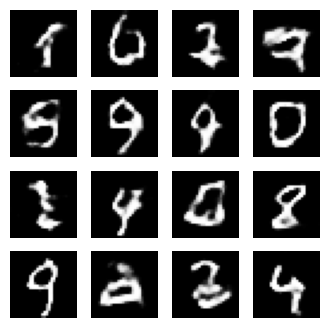

In [54]:
train(train_dataset, EPOCHS)


# create a GIF file :

In [56]:
anim_file ='mnist.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-56-860e7e443572>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-56-860e7e443572>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
